# Lesson 1 - Keras implementation of fast ai part 1 v2
- This is a Keras implementation of Jeremy Howard's fastai part 1 v2 lesson 1 (original version is in PyTorch)
- This has only been tested with the TensorFlow backend to Keras
- https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb
- [Lesson 1 & 2 notes](http://forums.fast.ai/t/deeplearning-lecnotes2/7515)

## [Jupyter Hotkeys](https://www.cheatography.com/weidadeyue/cheat-sheets/jupyter-notebook/)
(1) `Shift` + `Enter`: Execute the selected cell.<br/>
(2) `Tab`: pop up code completion or indent.<br/>
(3) `Shift` + `Tab`: pop up tip of the function. (Simple)<br/>
(4) `Shift` + `Tab`(2 times): pop up description of the function. (Detail)<br/>
(5) `Shift` + `Tab`(3 times): show description of the function in an extra window.<br/>
(6) Equal to (5), Type `?` before the function name. For example, `?np.exp` and then execute the cell.<br/>
(7) `??function_name`. For example, `??np.exp` to show the source code of the function.<br/>

[Reload submudule in IPython](https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython)<br/>
[autoreload](http://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.utils import *
from fastai.learner import *
from fastai.dataset import *

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Download dataset and do data augmentation
The dataset is available at http://files.fast.ai/data/dogscats.zip. You can download it directly on your server by running the following line in your terminal. `wget http://files.fast.ai/data/dogscats.zip` You should put the data in a subdirectory of this notebook's directory, called data/. 

In [2]:
PATH = "../data/dogscats/" #update with your path to cats and dogs
sz = 224

Loading in Keras' off the shelf/pretrained ResNet50 model.

***<span style="color: red">Note: the PyTorch course uses ResNet34. After many hours spent writing code to convert PyTorch models and weights into Keras. I opted to use Keras' ResNet50.</span>***

In [3]:
arch = ResNet50
data = ImageClassifierData.from_paths(path=PATH, tfms = tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


----
## Choosing a learning rate
The learning rate determines how quickly or how slowly you want to update the weights (or parameters). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method learn.lr_find() helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186), where we simply <font color="blue">keep increasing the learning rate from a very small value, until the loss starts decreasing. The purpose of learning rate finder is not to find the minimum, but figure out what learning rate is allowing us to decrease rapidly.</font> Instead we go back to the point where the lower learning rates quickly giving us a quick decrease in the loss. We can plot the learning rate across batches to see what this looks like.


<!-- ![learning_rate](./ipython_images/lr.jpeg) -->
<!-- img src="./ipython_images/lr.jpeg" alt="Drawing" style="width: 60%;"/ >
(Source: Andrew Ng’s Machine Learning course on Coursera)-->

   Learning Rate           |  Learning Rate Finder        
:-------------------------:|:-------------------------:
<img src="images/lr_1.png" alt="" style="width: 80%;"/>|<img src="images/lr_1-2.png" alt="" style="width: 80%;"/>


It's a orthogonal way to optimizers such as **Adam**, **Momentum**, and so on.<br/>
In fact, the fast.ai library is trying to figure out the right gradient descent version. Behind the scenes, it's something actually called **Adam**. And this technique is telling us this is the best learning rate to use, given the tweaks we're using, in this case, the Adam optimizer.<br/><br/>
**For more information**:
* [Paper - No More Pesky Learning Rates](https://arxiv.org/pdf/1206.1106.pdf) (Less effective)
* [Paper - Leslie N. Smith, "Cyclical Learning Rates for Training Neural Networks"](https://arxiv.org/abs/1506.01186)
* [Dynamic Learning Rate](http://wiki.fast.ai/index.php/Dynamic_learning_rates)
* [Improving the way we work with learning rate.](https://techburst.io/improving-the-way-we-work-with-learning-rate-5e99554f163b)
* [Train your deep model faster and sharper — two novel techniques](https://hackernoon.com/training-your-deep-model-faster-and-sharper-e85076c3b047)

[Magic Function](http://ipython.org/ipython-doc/dev/interactive/tutorial.html#magic-functions)<br/>
%%time - measure running time of a cell

In [9]:
??LR_Find()

In [11]:
??LR_Updater()

In [4]:
%%time
learn.lr_find(jump=10)

{'loss': 1000000000.0, 'lr': 1e-05, 'iteration': 0}
Epoch 1/1
204/360 [================>.............] - ETA: 1:21 - loss: 0.4194
best loss: 0.032150
best lr: 0.007356
best iteration: 172
205/360 [================>.............] - ETA: 1:20 - loss: 0.4176

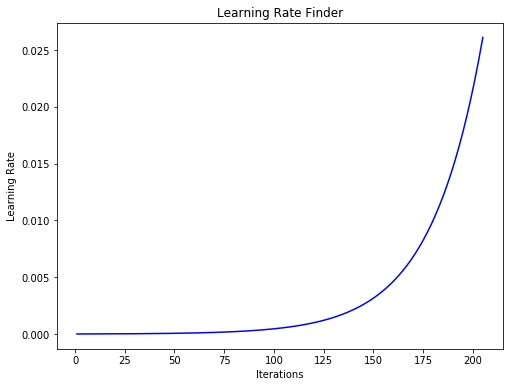

In [5]:
learn.sched.plot_lr(size=(8,6))

[Figure Annotation](https://matplotlib.org/users/annotations_intro.html)

{'loss': 0.032150164, 'lr': 0.0073564225, 'iteration': 172.0}


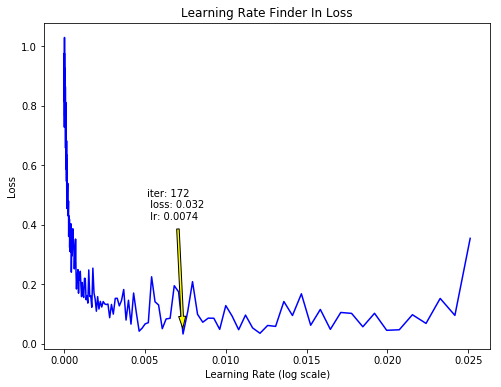

In [6]:
learn.sched.plot(log_scale=False)

As you can see in the plot above it appears the optimal learning rate to set is <span style="color:blue">0.01</span>.
### What the Fastai library does:
* uses the `Adam` optimizer. In Keras here, we only implemented in `SGD` (list other optimizers in TODO). 
* tries to find the fastest way to converge to a solution.

<hr style = 'background-color:green; border-width:0; color:green; height:1px; lineheight:0; display: inline-block; text-align: left; width:100%;' />
## Data Augmentation on the training data
Note that the pretrained Keras ResNet50 model is not quite as accurate as the pretrained PyTorch ResNet50 model.

If you try training for more epochs, you’ll notice that we start to <font color="red">**overfit** (the training loss is much lower than the validation loss), which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set.</font> <font color="blue">One way to fix this is to effectively create more data, through data augmentation.</font> This refers to randomly changing the images in ways that shouldn’t impact their interpretation, such as horizontal flipping, zooming, and rotating.

The pictures we saw where learn each different layer has these activations that basically look for anthing from the pictures. Literally what happens is that the last layers of CNN have these things called **activations**. <font color="red">Activation literally is a number that says the features like eyeball of a dog is in a location of the image with certain level of confidence and its probability.</font>
<img src="images/activations_1.png" alt="" style="width: 70%;"/>

A pretrained network is one where it's already learned to recognize certain things. In the case of the given image above, it's learned to recognize __1.5M images in ImageNet dataset__. 

### Note: this augmentation won’t doing anything because of precompute
In fast.ai, we take __second last layer__, so one which is like got all of the information necessary to figure out what kind of thing it is, and we can <font color="blue">save those activations, so we save the activations for every image, and call it **pre-computed activations**.</font><br/> In other words, we are using a pretrained network. We can take the 2nd last layer and save those activations. There is this level of “dog space” “eyeballs” etc. For efficiency, we use **Precomputed Activations** where we cache the activation values of the last of the Later Layers for each training image instead of recalculating each image each time it is in a minibatch, for about a 10x speedup.

<font color="green">When we'd like to create a new classifier which can basically take advantage of these pre-computed activations, we can quickly train, and remember all the details shortly, or train a linear model based on those. </font><br/>

<font color="red">When we create a learner, in order to use data augmentation, we have to set `learn.precompute = False` which sets all but the last layer to *frozen*. That means that It's still only updating the weights in the last layer.</font><img src="images/aug_1.jpg" alt="" style="width: 60%;"/>


In [7]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.RANDOM, 
                       rotation_range=10, 
                       zoom_range=0.1, 
                       horizontal_flip=True)

<font color="red">Note that **activation precomputation** is not implemented yet in this Keras library.</font>
We can quickly train a simple linear model based on these saved precomputed numbers. So the first time you run a model, it will take some time to calculate and compile. Then afterwards, it will train much faster.

In [8]:
#need to add random lighten
data = ImageClassifierData.from_paths(path=PATH, tfms = tfms)
learn = ConvLearner.pretrained(arch, data)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


<hr style = 'background-color:green; border-width:0; color:green; height:1px; lineheight:0; display: inline-block; text-align: left; width:100%;' />
## Learning Rate Annealing
Learning Rate Annealing is decreasing the learning rate as you train, hoping to find the nadir of the cost vs iteration function.
### Why do we use the learning rate that isn’t the lowest point?
Each time we iterate, we will double the learning rate. The purpose of this to find what learning rate is helping use to decrease quickly. The learning rate is going too high.
<img src="images/lr_2.jpg" alt="" style="width: 40%;"/>
Three simple annealing methods start the learning rate at a constant (as found above) and gradually decrease the learning rate each mini-batch: 
* <font color="blue">Step-wise Annealing</font> uses discrete decreases, sometimes in a manual or hacky way.
* <font color="blue">Linear Annealing</font> decreases learning rate a set amount per iteration.
* <font color="blue">Cosine Annealing</font> uses the cosine curve from 0 to 90 degrees to reduce slowly then quickly then slowly again. <br/><br/>
A more complicated method would good results is <font color="blue">Stochastic Gradient Decent With Restarts (SGDR)</font> which periodically resets a simple (usually cosine) linear annealing curve every one or more epochs. This hopes to settle in **broad valleys** corresponding to good solutions that aren’t too specific to the specific training images. 

These advanced SGDR routines work better than the approaches of a **Grid Search** (systematic search for good hyperparameter values) for a learning rate or **Ensemble** (run multiple models and take best result) of different starting points.

Compare the different learning rates over time with different methods.

|  Simple Annealing Choices |  Annealing With Restarts Choices|  
|:-------------------------:|:-------------------------:|
|<img src="images/lr_4.png" style="width: 100%;"/>|<img src="images/lr_5.png" style="width: 100%;"/>|

#### What is that `cycle_len` parameter? 
What we've done here is used a technique called stochastic gradient descent with restarts (SGDR)</font>, a variant of learning rate annealing, <font color="blue">which gradually decreases the learning rate as training progresses.</font> This is helpful because as we get closer to the optimal weights, we want to take smaller steps. The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is referred to as `the number of cycles`.

|  High dimensional Space   |  Cosine Annealing         |  SGDR Annealing           |
|:-------------------------:|:-------------------------:|:-------------------------:|
|<img src="images/lr_6.png" alt="" style="width: 100%;"/>|<img src="images/lr_7.png" alt="" style="width: 100%;"/>|<img src="images/lr_8.png" alt="" style="width: 100%;"/>|

<!--img src="images/lr_ann_3.png" alt="" style="width: 30%; float: right;"/-->

#### What do you do when you have more than one minima?
Sometimes one minima will be better than others (based on how well it generalizes). So sharply changing the learning rate has the idea that if we suddenly jump up the learning rate, we will get out of “narrow” minimum and find the most “generalized” minimum.

<img src="images/lr_3.png" alt="" style="width: 40%;"/>

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, <font color="blue">small changes to the weights may result in big changes to the loss.</font> We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will <font color="blue">force the model to jump to a different part of the weight space if the current area is </font>"<font color="red">spikey</font>". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a `cyclic LR schedule`):
<img src="images/sgdr.png" alt="" style="width: 80%;"/><br/>
<center>(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).</center>
As the figure shown here, where it is in high dimensional space, we got lots of different flat points that are actual local minima.

In [9]:
learn.fit(.005, 1)

Epoch 1/1
360/360 [==============================] - 264s 734ms/step - loss: 0.0840 - acc: 0.9658 - val_loss: 0.0664 - val_acc: 0.9800


Evaluate function may run a little slow.  I find that Keras generator's are not the fastest compared to the ones in the fastai PyTorch library.  Generally I try to load the entire dataset into memory, but since this repository is meant to be shared I opted for generators so that it works for a wider audience.

Fit for 3 epochs with a Cyclical Learning Rate

In [ ]:
learn.fit(.01, 3, cycle_len=1, cycle_mult=2)

epochs: 7
Epoch 1/7
360/360 [==============================] - 265s 736ms/step - loss: 0.0601 - acc: 0.9766 - val_loss: 0.0791 - val_acc: 0.9740
Epoch 2/7
360/360 [==============================] - 259s 719ms/step - loss: 0.0581 - acc: 0.9789 - val_loss: 0.0767 - val_acc: 0.9780
Epoch 3/7
213/360 [================>.............] - ETA: 1:37 - loss: 0.0480 - acc: 0.9824

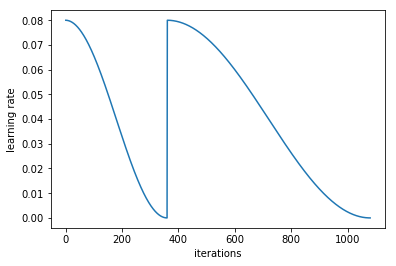

In [11]:
learn.sched.plot_lr()

In [12]:
learn.save('keras_resnet50.hdf5')

### Fine-tuning and differential learning rate annealing
Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.
#### In general you can only freeze layer from ‘n’ and on
Note that the other layers have already been trained to recognize ImageNet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we’ve seen) have more **general-purpose features**. <font color="blue">Therefore we would expect them to need less fine-tuning for new datasets.</font> For this reason we will use different learning rates for different layers: the first few layers will be at `1e-4`, the middle layers at `1e-3`, and our `Fully Connected (FC)` layers we’ll leave at `1e-2` as before. We refer to this as differential learning rates, although there’s no standard name for this technique in the literature that we’re aware of.
#### Specifying learning rates
We are going to specify ‘differential learning rates’ for different layers. We are grouping the blocks (ResNet blocks) in different areas and assigning different learning rates.

<font color="red">Reminder: we unfroze the layers and now we are retraining the whole set. The learning rate is smaller for early layers and making them larger for the ones farther away.</font>

In [13]:
learn.unfreeze()

In [14]:
learn.fit([0.0001, .001, .01], 3, cycle_len=1, cycle_mult=2)

Epoch 1/7
360/360 [==============================] - 223s - loss: 0.1533 - acc: 0.9847 - val_loss: 0.1801 - val_acc: 0.9855
Epoch 2/7
360/360 [==============================] - 219s - loss: 0.1379 - acc: 0.9854 - val_loss: 0.2030 - val_acc: 0.9800
Epoch 3/7
360/360 [==============================] - 220s - loss: 0.0975 - acc: 0.9893 - val_loss: 0.1973 - val_acc: 0.9795
Epoch 4/7
360/360 [==============================] - 219s - loss: 0.0953 - acc: 0.9892 - val_loss: 0.2123 - val_acc: 0.9790
Epoch 5/7
360/360 [==============================] - 220s - loss: 0.0722 - acc: 0.9912 - val_loss: 0.1732 - val_acc: 0.9790
Epoch 6/7
360/360 [==============================] - 219s - loss: 0.0722 - acc: 0.9916 - val_loss: 0.1342 - val_acc: 0.9845
Epoch 7/7
360/360 [==============================] - 220s - loss: 0.0614 - acc: 0.9921 - val_loss: 0.1560 - val_acc: 0.9850


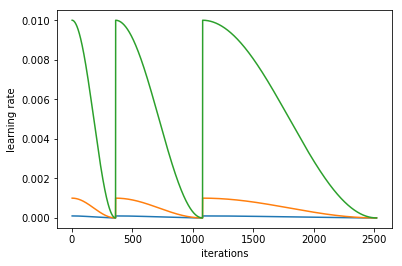

In [15]:
learn.sched.plot_lr()

### Test Time Augmentation (TTA)

In Natural Language Processing (NLP), we can try to replace words with synonyms. But the appropriate data augmentation for non-image domain is still under-researched/under-developed. 

In [16]:
%%time
learn.model.evaluate_generator(data[1], steps=math.ceil(data[1].samples/data[1].batch_size), workers=4 )

CPU times: user 19 s, sys: 284 ms, total: 19.3 s
Wall time: 6.77 s


[0.17039716272840053, 0.98450000000000004]

In [17]:
learn.save('keras_resnet50_2.hdf5')

### ResNet to ResNext 
See video at [1:51:07](https://youtu.be/JNxcznsrRb8?t=1h51m7s).<br/>
Since we changed our model from `ResNet` to `ResNext`, we have larger architecture which has more parameters, it wil be overfitting quickly. Thus, here we don't use `cycle_mult` to double the cycle length.

### Train with Larger Images
Most ImageNet models are trained on either 224x224 or 299x299 images.
If we pre-train a few epochs on our model with small size images like 224x224 at first, which is sort of overfit, then pass in images with larger size like 299x299 to train a few more epochs, it will make our model not overfit by chaning the size of images. To the model, the images are totally different although conceptually the model picks the same kinds of pictures or things. This trick training on small images for a few epochs and then switching to bigger images and then continuing training is an amazingly effectie way to avoid overfitting.

For more information:
* [Progressive Growing of GANs for Improved Quality, Stability, and Variation](https://arxiv.org/abs/1710.10196)